# TMDB Movie Data Analysis Pipeline

## Project Objectives:
- **API Data Extraction**: Fetch movie data from TMDB API
- **Data Cleaning & Transformation**: Process and structure data for analysis
- **Exploratory Data Analysis (EDA)**: Understand trends and patterns
- **Advanced Filtering & Ranking**: Identify best/worst movies by metrics
- **Franchise & Director Analysis**: Performance analysis over time
- **Visualization & Insights**: Present findings with visualizations

## Import Required Libraries

In [108]:
import pandas as pd
import requests
import numpy as np
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully")

Libraries imported successfully


## Step 1: Fetch Movie Data from API

We'll fetch specific movies using their TMDB IDs and store the data in a Pandas DataFrame.

In [109]:
API_KEY = "452a05ac647353f7965becf2f0e24c3b"
BASE_URL = "https://api.themoviedb.org/3/"

movie_ids = [0, 299534, 19995, 140607, 299536, 597, 135397, 420818, 24428, 
             168259, 99861, 284054, 12445, 181808, 330457, 351286, 109445, 
             321612, 260513]

In [110]:
def fetch_movie_details(movie_id, api_key):
    try:
        movie_url = f"{BASE_URL}movie/{movie_id}"
        params = {'api_key': api_key}
        
        response = requests.get(movie_url, params=params)
        
        if response.status_code == 200:
            movie_data = response.json()
            
            credits_url = f"{BASE_URL}movie/{movie_id}/credits"
            credits_response = requests.get(credits_url, params=params)
            
            director = None
            main_actors = []
            
            if credits_response.status_code == 200:
                credits_data = credits_response.json()
                
                for crew_member in credits_data.get('crew', []):
                    if crew_member.get('job') == 'Director':
                        director = crew_member.get('name')
                        break
                
                main_actors = [actor['name'] for actor in credits_data.get('cast', [])[:5]]
            
            return {
                'id': movie_data.get('id'),
                'title': movie_data.get('title'),
                'release_date': movie_data.get('release_date'),
                'runtime': movie_data.get('runtime'),
                'budget': movie_data.get('budget', 0),
                'revenue': movie_data.get('revenue', 0),
                'vote_average': movie_data.get('vote_average'),
                'vote_count': movie_data.get('vote_count'),
                'popularity': movie_data.get('popularity'),
                'genres': [genre['name'] for genre in movie_data.get('genres', [])],
                'director': director,
                'main_actors': main_actors,
                'production_companies': [company['name'] for company in movie_data.get('production_companies', [])],
                'production_countries': [country['name'] for country in movie_data.get('production_countries', [])],
                'original_language': movie_data.get('original_language'),
                'overview': movie_data.get('overview'),
                'status': movie_data.get('status')
            }
        else:
            print(f"Failed to fetch movie {movie_id}: {response.status_code}")
            return None
            
    except Exception as e:
        print(f"Error fetching movie {movie_id}: {str(e)}")
        return None

In [111]:
movies_data = []

for movie_id in movie_ids:
    if movie_id == 0:
        continue
    
    movie_data = fetch_movie_details(movie_id, API_KEY)
    
    if movie_data:
        movies_data.append(movie_data)
        print(f" {movie_data['title']} ({movie_data['release_date'][:4]})")

movies_df = pd.DataFrame(movies_data)
print(f"Total movies loaded: {len(movies_df)}")

 Avengers: Endgame (2019)
 Avatar (2009)
 Star Wars: The Force Awakens (2015)
 Avengers: Infinity War (2018)
 Titanic (1997)
 Jurassic World (2015)
 The Lion King (2019)
 The Avengers (2012)
 Furious 7 (2015)
 Avengers: Age of Ultron (2015)
 Black Panther (2018)
 Harry Potter and the Deathly Hallows: Part 2 (2011)
 Star Wars: The Last Jedi (2017)
 Frozen II (2019)
 Jurassic World: Fallen Kingdom (2018)
 Frozen (2013)
 Beauty and the Beast (2017)
 Incredibles 2 (2018)
Total movies loaded: 18


In [112]:
display(movies_df[['title', 'release_date', 'director', 'budget', 'revenue', 'vote_average']].head())
movies_df.info()

,title,release_date,director,budget,revenue,vote_average
0,Avengers: Endgame,2019-04-24,Joe Russo,356000000,2799439100,8.238
1,Avatar,2009-12-15,James Cameron,237000000,2923706026,7.594
2,Star Wars: The Force Awakens,2015-12-15,J.J. Abrams,245000000,2068223624,7.255
3,Avengers: Infinity War,2018-04-25,Anthony Russo,300000000,2052415039,8.236
4,Titanic,1997-11-18,James Cameron,200000000,2264162353,7.905


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    18 non-null     int64  
 1   title                 18 non-null     object 
 2   release_date          18 non-null     object 
 3   runtime               18 non-null     int64  
 4   budget                18 non-null     int64  
 5   revenue               18 non-null     int64  
 6   vote_average          18 non-null     float64
 7   vote_count            18 non-null     int64  
 8   popularity            18 non-null     float64
 9   genres                18 non-null     object 
 10  director              18 non-null     object 
 11  main_actors           18 non-null     object 
 12  production_companies  18 non-null     object 
 13  production_countries  18 non-null     object 
 14  original_language     18 non-null     object 
 15  overview              18 

## Step 2: Data Cleaning and Preprocessing

Now we'll clean and preprocess the raw movie data to prepare it for analysis.

In [113]:
# Initial Data Inspection
print(f"Dataset shape: {movies_df.shape}")
print(f"Columns: {list(movies_df.columns)}")

missing_values = movies_df.isnull().sum()
if missing_values.sum() > 0:
    print("Missing values:")
    for col, missing in missing_values.items():
        if missing > 0:
            print(f"  {col}: {missing}")
else:
    print("No missing values")

Dataset shape: (18, 17)
Columns: ['id', 'title', 'release_date', 'runtime', 'budget', 'revenue', 'vote_average', 'vote_count', 'popularity', 'genres', 'director', 'main_actors', 'production_companies', 'production_countries', 'original_language', 'overview', 'status']
No missing values


In [114]:
# Drop irrelevant columns
columns_to_drop = ['adult', 'imdb_id', 'original_title', 'video', 'homepage']
existing_columns_to_drop = [col for col in columns_to_drop if col in movies_df.columns]

if existing_columns_to_drop:
    movies_df = movies_df.drop(columns=existing_columns_to_drop)
    print(f"Dropped columns: {existing_columns_to_drop}")

print(f"New shape: {movies_df.shape}")

New shape: (18, 17)


In [115]:
# Check available columns for processing
json_columns = ['belongs_to_collection', 'genres', 'production_countries', 
                'production_companies', 'spoken_languages']

print("Available columns:")
for col in json_columns:
    if col in movies_df.columns:
        print(f"  {col}: Found")
    else:
        print(f"  {col}: Not found")

Available columns:
  belongs_to_collection: Not found
  genres: Found
  production_countries: Found
  production_companies: Found
  spoken_languages: Not found


In [116]:
# Extract and clean key data points
def list_to_pipe_separated(data_list):
    if isinstance(data_list, list) and len(data_list) > 0:
        return "|".join(str(item) for item in data_list)
    return ""

# Create cleaned columns
if 'belongs_to_collection' not in movies_df.columns:
    movies_df['collection_name'] = ""

if 'genres' in movies_df.columns:
    movies_df['genre_names'] = movies_df['genres'].apply(list_to_pipe_separated)
else:
    movies_df['genre_names'] = ""

if 'spoken_languages' not in movies_df.columns:
    movies_df['spoken_languages_clean'] = movies_df['original_language'].astype(str)
else:
    movies_df['spoken_languages_clean'] = movies_df['spoken_languages'].apply(list_to_pipe_separated)

if 'production_countries' in movies_df.columns:
    movies_df['production_countries_clean'] = movies_df['production_countries'].apply(list_to_pipe_separated)
else:
    movies_df['production_countries_clean'] = ""

if 'production_companies' in movies_df.columns:
    movies_df['production_companies_clean'] = movies_df['production_companies'].apply(list_to_pipe_separated)
else:
    movies_df['production_companies_clean'] = ""

print(f"Dataset shape after cleaning: {movies_df.shape}")

Dataset shape after cleaning: (18, 22)


In [117]:
# Inspect extracted columns
def show_value_counts(series, column_name, top_n=5):
    print(f"\n{column_name}:")
    
    if series.empty:
        print("  No data")
        return
    
    non_empty = series[series.notna() & (series != "")]
    
    if len(non_empty) == 0:
        print("  All empty")
        return
    
    if "|" in str(non_empty.iloc[0]):
        all_items = []
        for value in non_empty:
            items = str(value).split("|")
            all_items.extend([item.strip() for item in items if item.strip()])
        
        if all_items:
            counts = pd.Series(all_items).value_counts().head(top_n)
            for item, count in counts.items():
                print(f"  {item}: {count}")
    else:
        counts = non_empty.value_counts().head(top_n)
        for value, count in counts.items():
            print(f"  {value}: {count}")
    
    print(f"  Unique: {len(non_empty.unique())}, Empty: {len(series) - len(non_empty)}")

# Show value counts for cleaned columns
columns_to_inspect = ['genre_names', 'spoken_languages_clean', 
                     'production_countries_clean', 'production_companies_clean']

for col in columns_to_inspect:
    if col in movies_df.columns:
        show_value_counts(movies_df[col], col)


genre_names:
  Adventure: 15
  Action: 12
  Science Fiction: 10
  Fantasy: 5
  Family: 5
  Unique: 14, Empty: 0

spoken_languages_clean:
  en: 18
  Unique: 1, Empty: 0

production_countries_clean:
  United States of America: 16
  United States of America|United Kingdom: 1
  United Kingdom|United States of America: 1
  Unique: 3, Empty: 0

production_companies_clean:
  Marvel Studios: 5
  Walt Disney Animation Studios: 2
  Dune Entertainment|Lightstorm Entertainment|20th Century Fox|Ingenious Media: 1
  Paramount Pictures|20th Century Fox|Lightstorm Entertainment: 1
  Lucasfilm Ltd.|Bad Robot: 1
  Unique: 13, Empty: 0


In [118]:
# Data cleaning summary
print(f"Final dataset: {movies_df.shape}")

# Show sample of cleaned data
sample_columns = ['title', 'release_date', 'genre_names', 'production_countries_clean', 'director']
available_columns = [col for col in sample_columns if col in movies_df.columns]
if available_columns:
    display(movies_df[available_columns].head(3))

Final dataset: (18, 22)


,title,release_date,genre_names,production_countries_clean,director
0,Avengers: Endgame,2019-04-24,Adventure|Science Fiction|Action,United States of America,Joe Russo
1,Avatar,2009-12-15,Action|Adventure|Fantasy|Science Fiction,United States of America|United Kingdom,James Cameron
2,Star Wars: The Force Awakens,2015-12-15,Adventure|Action|Science Fiction,United States of America,J.J. Abrams


## Step 3: Exploratory Data Analysis (EDA)

Now we'll perform comprehensive exploratory analysis to understand trends, patterns, and insights in our movie dataset.

In [119]:
# Basic dataset statistics
print(f"Total movies: {len(movies_df)}")
print(f"Date range: {movies_df['release_date'].min()} to {movies_df['release_date'].max()}")

# Financial analysis
financial_data = movies_df[movies_df['budget'] > 0]
print(f"Movies with budget data: {len(financial_data)}/{len(movies_df)}")

if len(financial_data) > 0:
    print(f"Average budget: ${financial_data['budget'].mean():,.0f}")
    print(f"Average revenue: ${financial_data['revenue'].mean():,.0f}")
    
    roi_data = financial_data[(financial_data['budget'] > 0) & (financial_data['revenue'] > 0)]
    if len(roi_data) > 0:
        roi_data['roi'] = ((roi_data['revenue'] - roi_data['budget']) / roi_data['budget']) * 100
        print(f"Average ROI: {roi_data['roi'].mean():.1f}%")

# Rating analysis
print(f"Average rating: {movies_df['vote_average'].mean():.2f}/10")
print(f"Average votes: {movies_df['vote_count'].mean():,.0f}")

# Runtime analysis
runtime_data = movies_df[movies_df['runtime'].notna() & (movies_df['runtime'] > 0)]
if len(runtime_data) > 0:
    print(f"Average runtime: {runtime_data['runtime'].mean():.0f} minutes")

Total movies: 18
Date range: 1997-11-18 to 2019-11-20
Movies with budget data: 18/18
Average budget: $215,444,444
Average revenue: $1,691,831,828
Average ROI: 718.0%
Average rating: 7.39/10
Average votes: 20,308
Average runtime: 138 minutes


In [120]:
# Top performers analysis
print("TOP 5 BY RATING:")
top_rated = movies_df.nlargest(5, 'vote_average')[['title', 'vote_average', 'release_date']]
for idx, movie in top_rated.iterrows():
    print(f"  {movie['vote_average']:.1f} - {movie['title']} ({movie['release_date'][:4]})")

print("\nTOP 5 BY REVENUE:")
revenue_data = movies_df[movies_df['revenue'] > 0].nlargest(5, 'revenue')
for idx, movie in revenue_data.iterrows():
    print(f"  ${movie['revenue']/1_000_000:.0f}M - {movie['title']} ({movie['release_date'][:4]})")

# ROI leaders
roi_movies = movies_df[(movies_df['budget'] > 0) & (movies_df['revenue'] > 0)].copy()
if len(roi_movies) > 0:
    roi_movies['roi'] = ((roi_movies['revenue'] - roi_movies['budget']) / roi_movies['budget']) * 100
    
    print("\nTOP 5 BY ROI:")
    top_roi = roi_movies.nlargest(5, 'roi')
    for idx, movie in top_roi.iterrows():
        print(f"  {movie['roi']:,.0f}% - {movie['title']}")

print("\nTOP 5 BY POPULARITY:")
top_popular = movies_df.nlargest(5, 'popularity')[['title', 'popularity', 'release_date']]
for idx, movie in top_popular.iterrows():
    print(f"  {movie['popularity']:.1f} - {movie['title']} ({movie['release_date'][:4]})")

TOP 5 BY RATING:
  8.2 - Avengers: Endgame (2019)
  8.2 - Avengers: Infinity War (2018)
  8.1 - Harry Potter and the Deathly Hallows: Part 2 (2011)
  7.9 - Titanic (1997)
  7.8 - The Avengers (2012)

TOP 5 BY REVENUE:
  $2924M - Avatar (2009)
  $2799M - Avengers: Endgame (2019)
  $2264M - Titanic (1997)
  $2068M - Star Wars: The Force Awakens (2015)
  $2052M - Avengers: Infinity War (2018)

TOP 5 BY ROI:
  1,134% - Avatar
  1,032% - Titanic
  1,014% - Jurassic World
  973% - Harry Potter and the Deathly Hallows: Part 2
  869% - Frozen II

TOP 5 BY POPULARITY:
  46.4 - The Avengers (2012)
  30.1 - Avengers: Infinity War (2018)
  23.1 - Titanic (1997)
  21.0 - Avatar (2009)
  20.6 - Frozen (2013)


In [121]:
# Genre and director analysis
print("GENRE ANALYSIS:")
all_genres = []
for genre_string in movies_df['genre_names']:
    if isinstance(genre_string, str) and genre_string:
        genres = [g.strip() for g in genre_string.split('|')]
        all_genres.extend(genres)

if all_genres:
    genre_counts = pd.Series(all_genres).value_counts()
    print("Most popular genres:")
    for genre, count in genre_counts.head(5).items():
        print(f"  {genre}: {count} movies")

# Director analysis
print("\nDIRECTOR ANALYSIS:")
director_data = movies_df[movies_df['director'].notna() & (movies_df['director'] != '')]
if len(director_data) > 0:
    director_counts = director_data['director'].value_counts()
    multiple_movies = director_counts[director_counts > 1]
    
    if len(multiple_movies) > 0:
        print("Directors with multiple movies:")
        for director, count in multiple_movies.head(3).items():
            director_movies = director_data[director_data['director'] == director]
            avg_rating = director_movies['vote_average'].mean()
            print(f"  {director}: {count} movies, {avg_rating:.1f}")
    
    # Top-rated directors
    print("Highest rated directors:")
    director_ratings = director_data.groupby('director')['vote_average'].mean().sort_values(ascending=False)
    for director, rating in director_ratings.head(5).items():
        print(f"  {rating:.1f} {director}")

GENRE ANALYSIS:
Most popular genres:
  Adventure: 15 movies
  Action: 12 movies
  Science Fiction: 10 movies
  Fantasy: 5 movies
  Family: 5 movies

DIRECTOR ANALYSIS:
Directors with multiple movies:
  James Cameron: 2 movies, 7.7
  Joss Whedon: 2 movies, 7.5
Highest rated directors:
  8.2 Joe Russo
  8.2 Anthony Russo
  8.1 David Yates
  7.7 James Cameron
  7.5 Joss Whedon


In [122]:
# Temporal analysis
movies_df['release_year'] = pd.to_datetime(movies_df['release_date']).dt.year
movies_df['release_decade'] = (movies_df['release_year'] // 10) * 10

print("MOVIES BY DECADE:")
decade_counts = movies_df['release_decade'].value_counts().sort_index()
for decade, count in decade_counts.items():
    print(f"  {decade}s: {count} movies")

print("\nMOVIES BY YEAR:")
year_counts = movies_df['release_year'].value_counts().sort_index()
for year, count in year_counts.items():
    print(f"  {year}: {count} movies")

# Trends over time
print("\nTRENDS BY DECADE:")
temporal_analysis = movies_df.groupby('release_decade').agg({
    'vote_average': 'mean',
    'budget': lambda x: x[x > 0].mean() if len(x[x > 0]) > 0 else 0,
    'revenue': lambda x: x[x > 0].mean() if len(x[x > 0]) > 0 else 0
}).round(2)

for decade, data in temporal_analysis.iterrows():
    budget_text = f", avg budget ${data['budget']/1_000_000:.0f}M" if data['budget'] > 0 else ""
    revenue_text = f", avg revenue ${data['revenue']/1_000_000:.0f}M" if data['revenue'] > 0 else ""
    print(f"  {decade}s: {data['vote_average']:.1f}{budget_text}{revenue_text}")

MOVIES BY DECADE:
  1990s: 1 movies
  2000s: 1 movies
  2010s: 16 movies

MOVIES BY YEAR:
  1997: 1 movies
  2009: 1 movies
  2011: 1 movies
  2012: 1 movies
  2013: 1 movies
  2015: 4 movies
  2017: 2 movies
  2018: 4 movies
  2019: 3 movies

TRENDS BY DECADE:
  1990s: 7.9, avg budget $200M, avg revenue $2264M
  2000s: 7.6, avg budget $237M, avg revenue $2924M
  2010s: 7.3, avg budget $215M, avg revenue $1579M


In [123]:
# Production analysis
print("PRODUCTION COUNTRIES:")
all_countries = []
for country_string in movies_df['production_countries_clean']:
    if isinstance(country_string, str) and country_string:
        countries = [c.strip() for c in country_string.split('|')]
        all_countries.extend(countries)

if all_countries:
    country_counts = pd.Series(all_countries).value_counts()
    print("Most active countries:")
    for country, count in country_counts.head(5).items():
        print(f"  {country}: {count} movies")

print("\nPRODUCTION COMPANIES:")
all_companies = []
for company_string in movies_df['production_companies_clean']:
    if isinstance(company_string, str) and company_string:
        companies = [c.strip() for c in company_string.split('|')]
        all_companies.extend(companies)

if all_companies:
    company_counts = pd.Series(all_companies).value_counts()
    print("Most active companies:")
    for company, count in company_counts.head(5).items():
        print(f"  {company}: {count} movies")

PRODUCTION COUNTRIES:
Most active countries:
  United States of America: 18 movies
  United Kingdom: 2 movies

PRODUCTION COMPANIES:
Most active companies:
  Marvel Studios: 5 movies
  Universal Pictures: 3 movies
  20th Century Fox: 2 movies
  Lightstorm Entertainment: 2 movies
  Walt Disney Animation Studios: 2 movies


In [124]:
# EDA summary and key insights
total_movies = len(movies_df)
avg_rating = movies_df['vote_average'].mean()
financial_movies = movies_df[(movies_df['budget'] > 0) & (movies_df['revenue'] > 0)]

print("DATASET OVERVIEW:")
print(f"  Movies: {total_movies}")
print(f"  Time period: {movies_df['release_date'].min()} to {movies_df['release_date'].max()}")
print(f"  Average rating: {avg_rating:.2f}/10")
print(f"  Movies with financial data: {len(financial_movies)}")

print("\nKEY INSIGHTS:")

# Highest rated
highest_rated = movies_df.loc[movies_df['vote_average'].idxmax()]
print(f"  Highest rated: {highest_rated['title']} ({highest_rated['vote_average']}/10)")

# Financial insights
if len(financial_movies) > 0:
    most_profitable = financial_movies.loc[financial_movies['revenue'].idxmax()]
    print(f"  Highest revenue: {most_profitable['title']} (${most_profitable['revenue']:,.0f})")
    
    roi_data = financial_movies.copy()
    roi_data['roi'] = ((roi_data['revenue'] - roi_data['budget']) / roi_data['budget']) * 100
    best_roi = roi_data.loc[roi_data['roi'].idxmax()]
    print(f"  Best ROI: {best_roi['title']} ({best_roi['roi']:.0f}%)")

# Popular genre
all_genres = []
for genre_string in movies_df['genre_names']:
    if isinstance(genre_string, str) and genre_string:
        all_genres.extend([g.strip() for g in genre_string.split('|')])

if all_genres:
    most_common_genre = pd.Series(all_genres).value_counts().index[0]
    genre_count = pd.Series(all_genres).value_counts().iloc[0]
    print(f"  Most common genre: {most_common_genre} ({genre_count} movies)")

print("\nEDA Complete!")

DATASET OVERVIEW:
  Movies: 18
  Time period: 1997-11-18 to 2019-11-20
  Average rating: 7.39/10
  Movies with financial data: 18

KEY INSIGHTS:
  Highest rated: Avengers: Endgame (8.238/10)
  Highest revenue: Avatar ($2,923,706,026)
  Best ROI: Avatar (1134%)
  Most common genre: Adventure (15 movies)

EDA Complete!


## Step 4: Movie Filtering and Ranking

Basic filtering and ranking of movies by different criteria.

In [125]:
# Filter movies by rating
high_rated = movies_df[movies_df['vote_average'] >= 8.0]
print(f"High rated movies (8.0+): {len(high_rated)}")
if len(high_rated) > 0:
    for idx, movie in high_rated.iterrows():
        print(f"  {movie['vote_average']:.1f} - {movie['title']} ({movie['release_date'][:4]})")

# Filter by genre
action_movies = movies_df[movies_df['genre_names'].str.contains('Action', case=False, na=False)]
print(f"\nAction movies: {len(action_movies)}")
if len(action_movies) > 0:
    print("Top action movies:")
    for idx, movie in action_movies.nlargest(3, 'vote_average').iterrows():
        print(f"  {movie['vote_average']:.1f} - {movie['title']}")

# Filter by year
recent_movies = movies_df[movies_df['release_year'] >= 2010]
print(f"\nRecent movies (2010+): {len(recent_movies)}")

High rated movies (8.0+): 3
  8.2 - Avengers: Endgame (2019)
  8.2 - Avengers: Infinity War (2018)
  8.1 - Harry Potter and the Deathly Hallows: Part 2 (2011)

Action movies: 12
Top action movies:
  8.2 - Avengers: Endgame
  8.2 - Avengers: Infinity War
  7.8 - The Avengers

Recent movies (2010+): 16


In [126]:
# Rank movies by different criteria
print("TOP 5 BY RATING:")
top_rated = movies_df.nlargest(5, 'vote_average')
for idx, movie in top_rated.iterrows():
    print(f"  {movie['vote_average']:.1f} - {movie['title']}")

print("\nTOP 5 BY POPULARITY:")
top_popular = movies_df.nlargest(5, 'popularity')
for idx, movie in top_popular.iterrows():
    print(f"  {movie['popularity']:.1f} - {movie['title']}")

# Simple ROI calculation
financial_movies = movies_df[(movies_df['budget'] > 0) & (movies_df['revenue'] > 0)].copy()
if len(financial_movies) > 0:
    financial_movies['profit'] = financial_movies['revenue'] - financial_movies['budget']
    print("\nMOST PROFITABLE:")
    for idx, movie in financial_movies.nlargest(3, 'profit').iterrows():
        profit_m = movie['profit'] / 1_000_000
        print(f"  ${profit_m:.0f}M - {movie['title']}")

TOP 5 BY RATING:
  8.2 - Avengers: Endgame
  8.2 - Avengers: Infinity War
  8.1 - Harry Potter and the Deathly Hallows: Part 2
  7.9 - Titanic
  7.8 - The Avengers

TOP 5 BY POPULARITY:
  46.4 - The Avengers
  30.1 - Avengers: Infinity War
  23.1 - Titanic
  21.0 - Avatar
  20.6 - Frozen

MOST PROFITABLE:
  $2687M - Avatar
  $2443M - Avengers: Endgame
  $2064M - Titanic


## Step 5: Director Analysis

Simple analysis of director performance in the dataset.

In [127]:
# Analyze directors in the dataset
director_data = movies_df[movies_df['director'].notna() & (movies_df['director'] != '')]

if len(director_data) > 0:
    # Count movies per director
    director_counts = director_data['director'].value_counts()
    print("Directors with multiple movies:")
    multiple_movies = director_counts[director_counts > 1]
    for director, count in multiple_movies.items():
        print(f"  {director}: {count} movies")
    
    # Average ratings by director
    director_ratings = director_data.groupby('director')['vote_average'].mean().sort_values(ascending=False)
    print(f"\nTop directors by average rating:")
    for director, rating in director_ratings.head(5).items():
        movie_count = director_counts[director]
        print(f"  {rating:.1f} - {director} ({movie_count} movies)")
else:
    print("No director data available")

Directors with multiple movies:
  James Cameron: 2 movies
  Joss Whedon: 2 movies

Top directors by average rating:
  8.2 - Joe Russo (1 movies)
  8.2 - Anthony Russo (1 movies)
  8.1 - David Yates (1 movies)
  7.7 - James Cameron (2 movies)
  7.5 - Joss Whedon (2 movies)


## Step 6: Basic Visualizations

Simple charts to visualize the movie data.

Creating basic visualizations...


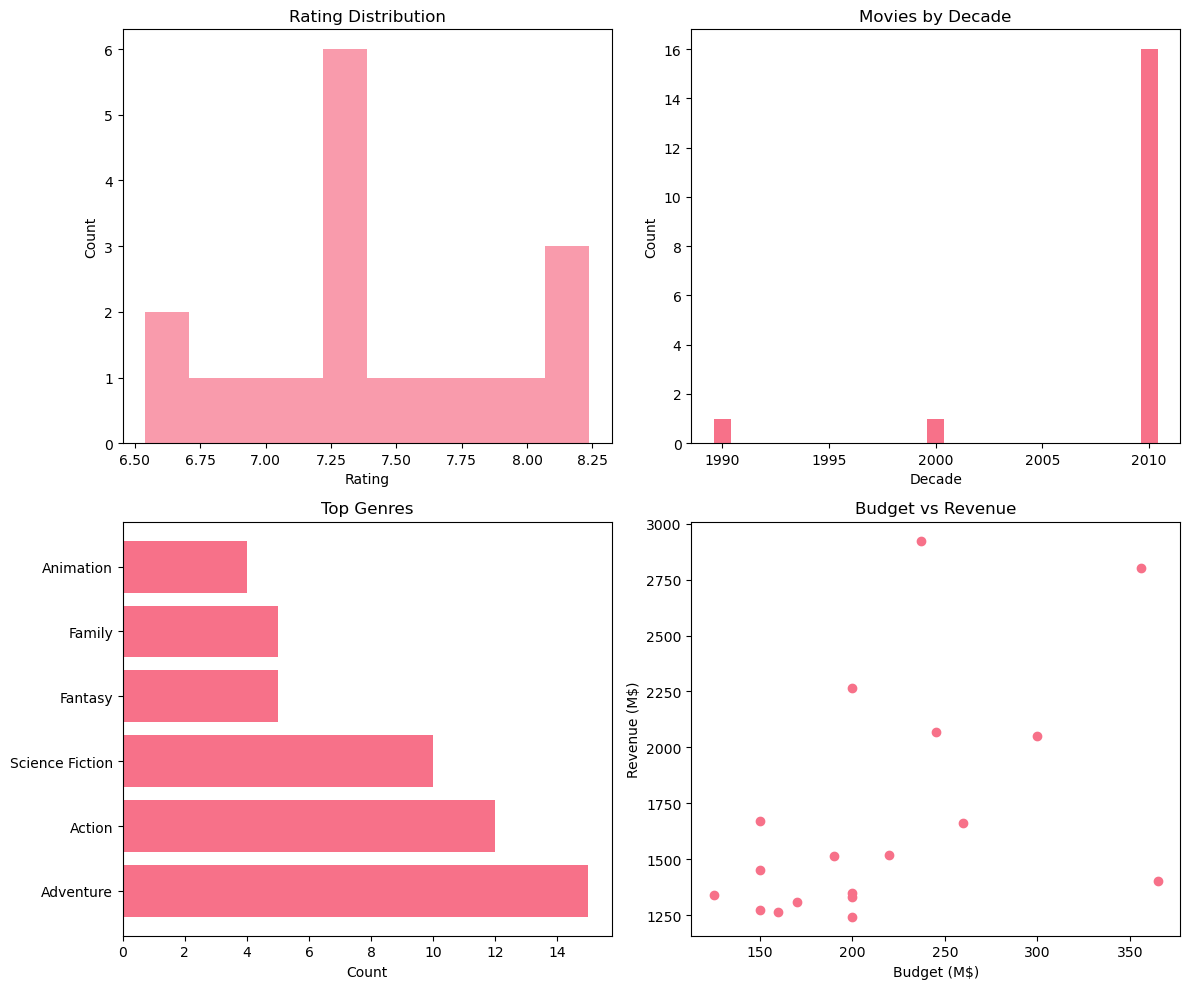

In [128]:
# Simple visualizations
if VISUALIZATION_AVAILABLE:
    print("Creating basic visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Rating distribution
    axes[0, 0].hist(movies_df['vote_average'], bins=10, alpha=0.7)
    axes[0, 0].set_title('Rating Distribution')
    axes[0, 0].set_xlabel('Rating')
    axes[0, 0].set_ylabel('Count')
    
    # Movies by decade
    decade_counts = movies_df['release_decade'].value_counts().sort_index()
    axes[0, 1].bar(decade_counts.index, decade_counts.values)
    axes[0, 1].set_title('Movies by Decade')
    axes[0, 1].set_xlabel('Decade')
    axes[0, 1].set_ylabel('Count')
    
    # Top genres
    all_genres = []
    for genre_string in movies_df['genre_names']:
        if isinstance(genre_string, str) and genre_string:
            all_genres.extend([g.strip() for g in genre_string.split('|')])
    
    if all_genres:
        genre_counts = pd.Series(all_genres).value_counts().head(6)
        axes[1, 0].barh(genre_counts.index, genre_counts.values)
        axes[1, 0].set_title('Top Genres')
        axes[1, 0].set_xlabel('Count')
    
    # Budget vs Revenue
    financial_data = movies_df[(movies_df['budget'] > 0) & (movies_df['revenue'] > 0)]
    if len(financial_data) > 0:
        axes[1, 1].scatter(financial_data['budget']/1_000_000, financial_data['revenue']/1_000_000)
        axes[1, 1].set_title('Budget vs Revenue')
        axes[1, 1].set_xlabel('Budget (M$)')
        axes[1, 1].set_ylabel('Revenue (M$)')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Visualization libraries not available")

In [129]:
# Summary of findings
print("MOVIE ANALYSIS SUMMARY")
print("=" * 40)

print(f"Total movies analyzed: {len(movies_df)}")
print(f"Average rating: {movies_df['vote_average'].mean():.2f}")

# Best movie
best_movie = movies_df.loc[movies_df['vote_average'].idxmax()]
print(f"Highest rated: {best_movie['title']} ({best_movie['vote_average']}/10)")

# Most popular genres
all_genres = []
for genre_string in movies_df['genre_names']:
    if isinstance(genre_string, str) and genre_string:
        all_genres.extend([g.strip() for g in genre_string.split('|')])

if all_genres:
    most_common_genre = pd.Series(all_genres).value_counts().index[0]
    print(f"Most common genre: {most_common_genre}")

# Financial data
financial_movies = movies_df[(movies_df['budget'] > 0) & (movies_df['revenue'] > 0)]
if len(financial_movies) > 0:
    highest_revenue = financial_movies.loc[financial_movies['revenue'].idxmax()]
    print(f"Highest revenue: {highest_revenue['title']} (${highest_revenue['revenue']:,})")

MOVIE ANALYSIS SUMMARY
Total movies analyzed: 18
Average rating: 7.39
Highest rated: Avengers: Endgame (8.238/10)
Most common genre: Adventure
Highest revenue: Avatar ($2,923,706,026)
